In [7]:
!nvidia-smi

Thu Aug  1 10:17:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| 23%   34C    P2    44W / 175W |    956MiB /  7951MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import time
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

from src.data import blend
from src.models import PretrainedUNet
from src.mobilenet_v2 import MobileNetV2
from src.unet_mobilenet import UNetMobileNet
from src.metrics import jaccard, dice

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
data_folder = Path("data")
models_folder = Path("models")
images_folder = Path("images")
data_description = pd.read_csv(data_folder / "train.csv")

In [5]:
img_folder = Path("images")

In [13]:
mobile_unet = UNetMobileNet(num_classes=1, pretrained=False)
mobile_unet.load_state_dict(torch.load(models_folder / "hs-mobile-unet-v0.pt", map_location=torch.device("cpu")))
mobile_unet.to(device)
mobile_unet.eval();

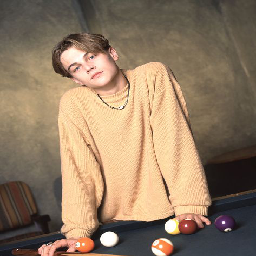

In [9]:
new_width = 256
new_height = 256
test_img = Image.open(img_folder / 'dicap.jpg')
width, height = test_img.size 

# left = (width - new_width)/2
# top = (height - new_height)/2
# right = (width + new_width)/2
# bottom = (height + new_height)/2

# test_img = test_img.crop((left, top, right, bottom))
# torch_img = torchvision.transforms.functional.to_tensor(test_img) - 0.5
test_img = test_img.resize((new_width, new_height))
test_img

/home/devel/Documents/ucu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


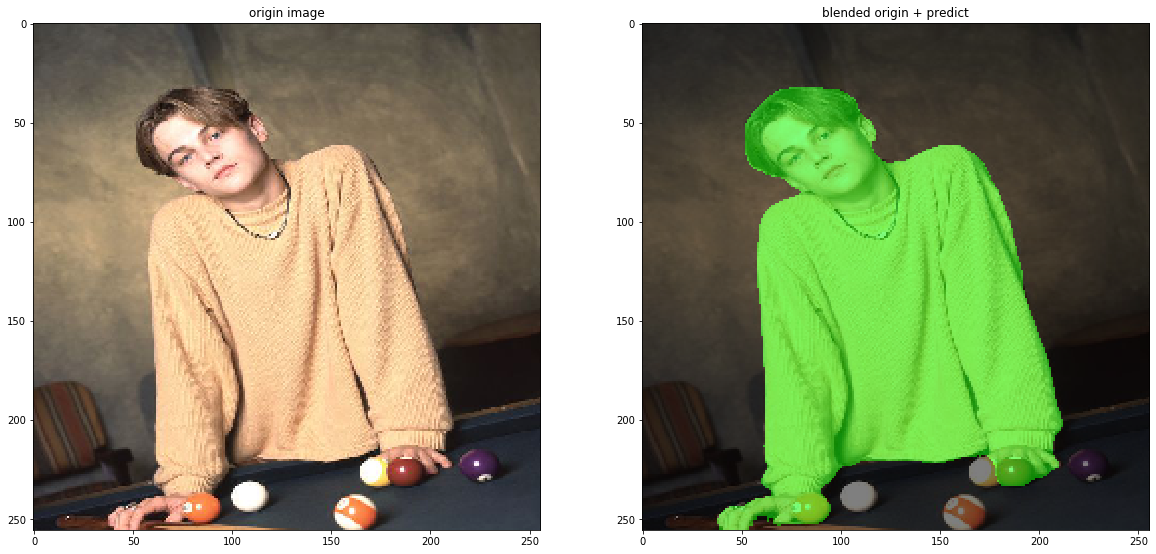

In [12]:
threshold = 0.5
origin = torchvision.transforms.functional.to_tensor(test_img) - 0.5
origin = origin.unsqueeze(0)


with torch.no_grad():
    origin = torchvision.transforms.functional.to_tensor(test_img) - 0.5
    origin = origin.unsqueeze(0)

    origin = origin.to(device)

    out = mobile_unet(origin)
    out = torch.sigmoid(out)
    out = (out > threshold)
    
    origin = origin[0]
    out = out[0][0]
    
    origin = origin.to("cpu")
    out = out.to("cpu")

plt.figure(figsize=(20, 10))
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

plt.subplot(1, 2, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 2, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin + 0.5, out)));
plt.savefig(images_folder / "unet-mobilenet-example.png", bbox_inches='tight')

In [45]:
with torch.no_grad():
    t1 = time.time()
    for i in range(100):
        inp = torch_img.float().to(device)
        out = mobile_unet(inp.unsqueeze(0))
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
    print(f'FPS: {100/ (time.time()-t1)}')
    out = out[0].to("cpu")
    


FPS: 41.063910943395044
